In [6]:
# This code cell imports stuff, etc.

import numpy as np
import matplotlib.pyplot as plt
from time import time as tm
import seaborn as sns

# Import local functions and params
from utils import *
from SpikingNetworkModels import EIFNetworkSim
from DefaultParams import *


print('rBal = ',1000*rBal[0],1000*rBal[1],'Hz')

# Params for multi-trial sims
numtrials=20
dtRate=250

rBal =  5.823529411764702 15.882352941176466 Hz


In [7]:
# This code cell creates connectivity, stimulus, and runs sims

import warnings


    
# Get connectivity matrix
J=GetBlockErdosRenyi(Ns,Jm,P,Ns)

# External input on top of baseline
X=np.zeros((StimDim,Nt))
for j in range(StimDim):
  X[j,:]=MakeSmoothGaussianProcess(taustim,Nt,dt)

#Jx=np.zeros(N,StimDim)
Jx=sigmastim*(0.2*np.random.rand(N,StimDim)+0.3)
Jx[Ne:,:]=0

maxns=int(.05*Ne*Nt)+1
Ierecord=[0,1,2]
t0=tm()
RateTime=np.arange(0,T,dtRate)
re = np.zeros((numtrials,Ne,len(RateTime)))
ri = np.zeros((numtrials,Ni,len(RateTime)))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    for iii in range(numtrials):        
        se,si,VeRec = EIFNetworkSim(J,Jx,X,X0,Ne,NeuronParams,tau,Nt,dt,maxns,Ierecord)
        se=se[:,se[0,:]>=0]
        si=si[:,si[0,:]>=0]
        re[iii,:,:] = GetSpikeCounts(se,dtRate,Ne,T)/dtRate
        ri[iii,:,:] = GetSpikeCounts(si,dtRate,Ni,T)/dtRate
        print('Sim for trial',iii,'of',numtrials,'complete after',tm()-t0,'s')        
tSim=tm()-t0
print('Time for all sims:',tSim,'s')


MeanERates=re.mean()
MeanIRates=ri.mean()

print('rSim =',1000*MeanERates,1000*MeanIRates,'Hz')


Sim for trial 0 of 20 complete after 36.01233983039856 s
Sim for trial 1 of 20 complete after 71.99709677696228 s
Sim for trial 2 of 20 complete after 108.01539778709412 s
Sim for trial 3 of 20 complete after 143.95391511917114 s
Sim for trial 4 of 20 complete after 179.94625687599182 s
Sim for trial 5 of 20 complete after 215.90163803100586 s
Sim for trial 6 of 20 complete after 251.91971707344055 s
Sim for trial 7 of 20 complete after 288.8524429798126 s
Sim for trial 8 of 20 complete after 1195.288519859314 s
Sim for trial 9 of 20 complete after 1229.95272898674 s
Sim for trial 10 of 20 complete after 1265.0830357074738 s
Sim for trial 11 of 20 complete after 1541.3884468078613 s
Sim for trial 12 of 20 complete after 1576.8146159648895 s
Sim for trial 13 of 20 complete after 1613.1701629161835 s
Sim for trial 14 of 20 complete after 1649.6351590156555 s
Sim for trial 15 of 20 complete after 1685.894187927246 s
Sim for trial 16 of 20 complete after 1721.9087898731232 s
Sim for trial 

2047 of 4000 E neurons made the cut.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
20
Mean EE corr: 0.10774384960868257
Std EE corr: 0.20273794937340137
Mean connected EE corr: 0.11650452993457325
Mean unconnected EE corr: 0.10676298258373365


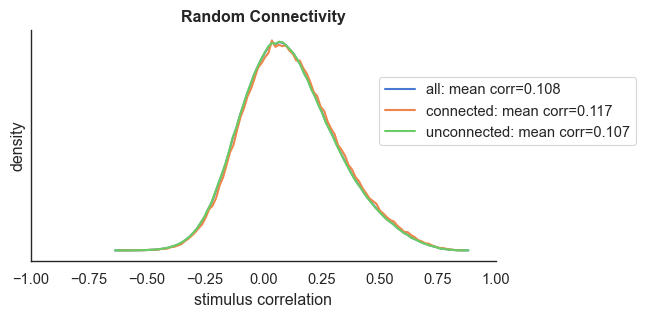

In [26]:
import seaborn as sns

sns.set(context='paper',style='white',font_scale=1.2,rc={"lines.linewidth":1.5})
sns.set_palette('muted')
#%config InlineBackend.figure_format = 'retina'

rmin=1.0/1000

nt=numtrials

# Counts from rates with burn-in and losing last bins bc of noise stuff
ECounts = dtRate*re[:nt,:,int(Tburn/dtRate)+1:int(-3*taustim/dtRate)-1]


# Average over trials
#ECounts = ECounts.mean(axis=0)
ECounts=ECounts[0,:,:]


ECutoffInds=np.where(ECounts.sum(axis=1)>T*rmin)[0]
print(len(ECutoffInds),'of',Ne,'E neurons made the cut.')
CutoffEECorrMatrix=np.corrcoef(ECounts[ECutoffInds])
AllEECorrs = CutoffEECorrMatrix[np.triu_indices_from(CutoffEECorrMatrix,k=1)]


Jee=J[:Ne,:Ne]
JeeCutoff=Jee[ECutoffInds,:][:,ECutoffInds]
ConnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(JeeCutoff,k=1))]
UnconnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(np.logical_not(JeeCutoff),k=1))]

print(nt)
print('Mean EE corr:',AllEECorrs.mean())
print('Std EE corr:',AllEECorrs.std())

print('Mean connected EE corr:',ConnectedEECorrs.mean())
print('Mean unconnected EE corr:',UnconnectedEECorrs.mean())



hAllEE,bAllEE=np.histogram(AllEECorrs,100,density=True)
hConnEE,bConnEE=np.histogram(ConnectedEECorrs,100,density=True)
hUnconnEE,bUnconnEE=np.histogram(UnconnectedEECorrs,100,density=True)

plt.figure(figsize=(6,3))
plt.plot(bAllEE[1:],hAllEE, label="all: mean corr={:.3f}".format(AllEECorrs.mean()))
plt.plot(bConnEE[1:],hConnEE, label="connected: mean corr={:.3f}".format(ConnectedEECorrs.mean()))
plt.plot(bUnconnEE[1:],hUnconnEE, label="unconnected: mean corr={:.3f}".format(UnconnectedEECorrs.mean()))
plt.ylabel('density')
plt.xlabel('stimulus correlation')
plt.legend(loc=(.75,.5))
plt.xlim([-1,1])
plt.title('Random Connectivity', weight='bold')
plt.yticks([])
sns.despine()

# Save figure if needed
SaveFigures=True
if SaveFigures:
      plt.savefig('./Figures/MultiTrialRandomConn.png')



rSim = 5.258289375000001 14.316175000000003 Hz


[]

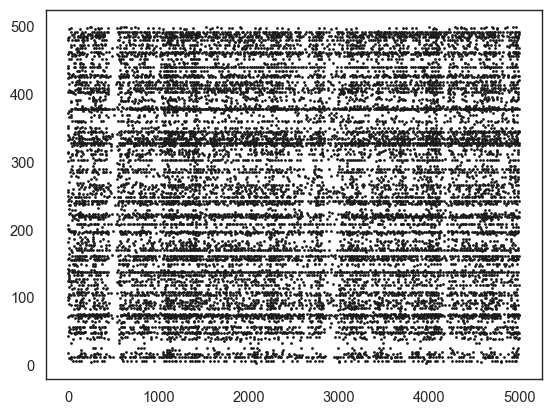

In [9]:

print('rSim =',1000*MeanERates,1000*MeanIRates,'Hz')


plt.figure()
NePlot=500
TPlot=5000
msize=2
Inds=np.where(np.logical_and(se[1,:]<NePlot , se[0,:]<=TPlot))
plt.plot(se[0,Inds],se[1,Inds]+1,'k.',markersize=msize)

# plt.figure()
# whichV=0
# Vplot=VeRec[time<=TPlot,whichV]
# PlotSpikeTimeInds = (se[0,se[1,:]==Ierecord[whichV]]/dt).astype(int)
# Vplot[PlotSpikeTimeInds]=0
# Vplot[Vplot>=0]=0

# plt.plot(time[time<=TPlot],Vplot)

[]

(5000, 1) (1, 200000) (5, 200000)


[]

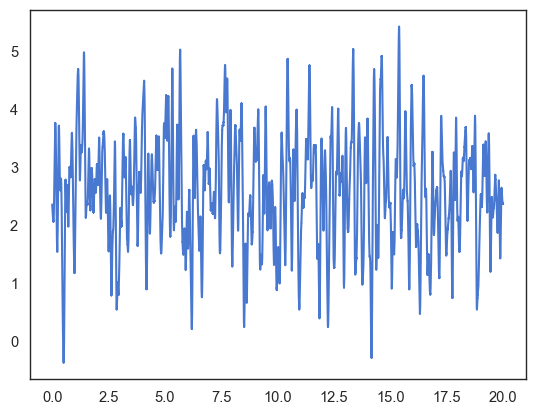

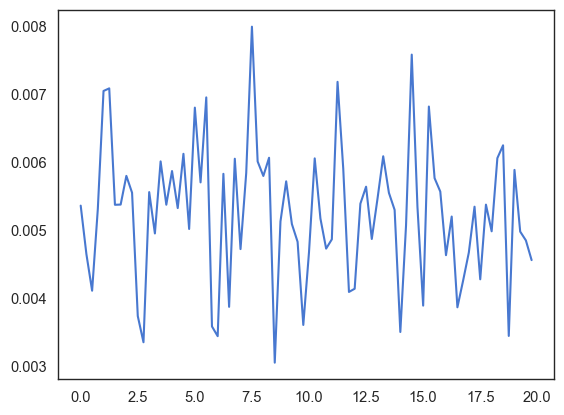

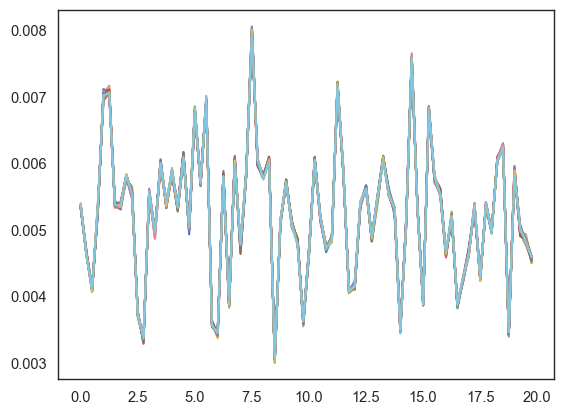

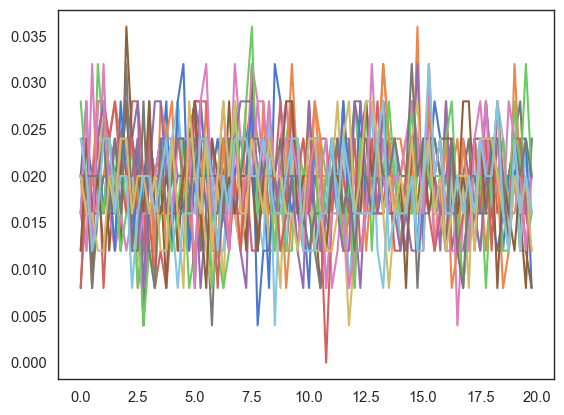

In [10]:
print(Jx.shape,X.shape,(Jx[:5,:]@X).shape)

cellnum=12

plt.figure()
plt.plot(time/1000,(X+X0[0]).T)
#plt.plot(RateTime/1000,re[:,cellnum,:].mean(axis=0)*dtRate)
#plt.plot(RateTime/1000,1000*re.mean(axis=(0,1)).T)

[]

plt.figure()
plt.plot(RateTime/1000,re.mean(axis=(0,1)).T)

plt.figure()
plt.plot(RateTime/1000,re.mean(axis=(1)).T)


plt.figure()
plt.plot(RateTime/1000,re[:,cellnum,:].T)
[]